In [10]:
import requests
import pandas as pd

TOKEN_URL = "https://login.impect.com/auth/realms/production/protocol/openid-connect/token"
BASE_API_URL = "https://api.impect.com"

USERNAME = "marclambertsmedia@gmail.com"
PASSWORD = "Meneertosti@1!"

ITERATION_ID = "1421"
OUTPUT_XLSX = f"/Users/user/IMPECT/Matches/iteration_{ITERATION_ID}_matches.xlsx"
SHEET_NAME = "matches"

# --- auth ---
token = requests.post(
    TOKEN_URL,
    data={
        "client_id": "api",
        "grant_type": "password",
        "username": USERNAME,
        "password": PASSWORD,
    },
    headers={"Content-Type": "application/x-www-form-urlencoded"},
    timeout=30,
).json()["access_token"]

headers = {"Authorization": f"Bearer {token}", "Accept": "application/json"}

def get_json(url, params=None):
    r = requests.get(url, headers=headers, params=params, timeout=60)
    r.raise_for_status()
    return r.json()

def unwrap(j):
    return j.get("data", j)

# --- 1) squads for iteration: build id -> name map ---
squads = unwrap(get_json(f"{BASE_API_URL}/v5/customerapi/iterations/{ITERATION_ID}/squads"))
squad_name_map = {str(s["id"]): s.get("name", "") for s in squads if isinstance(s, dict) and "id" in s}

# --- 2) matches for iteration ---
matches = unwrap(get_json(f"{BASE_API_URL}/v5/customerapi/iterations/{ITERATION_ID}/matches"))
df = pd.json_normalize(matches)
df.columns = [c.replace(".", "_") for c in df.columns]

# ensure match id column name
if "id" not in df.columns and "matchId" in df.columns:
    df["id"] = df["matchId"]

# add team names
df["homeTeam"] = df["homeSquadId"].astype(str).map(squad_name_map)
df["awayTeam"] = df["awaySquadId"].astype(str).map(squad_name_map)

# title: "Team vs Team" (+ date if available)
df["title"] = df["homeTeam"].fillna("") + " vs " + df["awayTeam"].fillna("")
if "scheduledDate" in df.columns:
    df["title"] = df["title"] + " (" + df["scheduledDate"].astype(str) + ")"

# output columns
out_cols = [c for c in ["id","title","homeTeam","awayTeam","homeSquadId","awaySquadId","scheduledDate","available","iterationId"] if c in df.columns]
df_out = df[out_cols].sort_values("id").reset_index(drop=True)

# save
with pd.ExcelWriter(OUTPUT_XLSX, engine="openpyxl") as writer:
    df_out.to_excel(writer, sheet_name=SHEET_NAME, index=False)

df_out.head(20), f"✅ Saved: {OUTPUT_XLSX}"


(        id                                              title  \
 0   209490  Bohemians Prag 1905 vs FC Banik Ostrau (2025-0...   
 1   209491  SK Slavia Prag vs FC Hradec Kralove (2025-07-2...   
 2   209492       FK Teplice vs FC Zlin (2025-07-19T15:00:00Z)   
 3   209493  FK Jablonec vs AC Sparta Prag (2025-07-19T18:0...   
 4   209494  1. FC Slovacko vs SK Sigma Olmütz (2025-07-20T...   
 5   209495  MFK Karvina vs FK Dukla Prag (2025-07-19T15:00...   
 6   209496  FK Pardubice vs FC Viktoria Pilsen (2025-07-18...   
 7   209497  FK Mlada Boleslav vs FC Slovan Liberec (2025-0...   
 8   209498  SK Sigma Olmütz vs FK Dukla Prag (2025-07-26T1...   
 9   209499  FC Slovan Liberec vs FK Pardubice (2025-07-27T...   
 10  209500  AC Sparta Prag vs FK Mlada Boleslav (2025-07-2...   
 11  209501   FC Zlin vs 1. FC Slovacko (2025-07-26T15:00:00Z)   
 12  209502  FC Viktoria Pilsen vs FK Jablonec (2025-07-26T...   
 13  209503  FC Hradec Kralove vs MFK Karvina (2025-07-26T1...   
 14  20950

In [12]:
import requests
import pandas as pd
from time import sleep
import os
import re

TOKEN_URL = "https://login.impect.com/auth/realms/production/protocol/openid-connect/token"
BASE_API_URL = "https://api.impect.com"

USERNAME = "marclambertsmedia@gmail.com"
PASSWORD = "Meneertosti@1!"

INPUT_XLSX = "/Users/user/IMPECT/Matches/iteration_1421_matches.xlsx"
MATCHES_SHEET = "matches"

OUTPUT_DIR = "/Users/user/IMPECT/Matches/events/CZE"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# -------------------------
# Auth
# -------------------------
token = requests.post(
    TOKEN_URL,
    data={
        "client_id": "api",
        "grant_type": "password",
        "username": USERNAME,
        "password": PASSWORD,
    },
    headers={"Content-Type": "application/x-www-form-urlencoded"},
    timeout=30,
).json()["access_token"]

headers = {"Authorization": f"Bearer {token}", "Accept": "application/json"}

def get_json(url):
    r = requests.get(url, headers=headers, timeout=60)
    r.raise_for_status()
    return r.json()

def unwrap(j):
    return j.get("data", j)

def safe_filename(s: str) -> str:
    """
    Remove characters not allowed in filenames
    """
    s = re.sub(r'[\\/:*?"<>|]', '', s)
    s = re.sub(r'\s+', ' ', s).strip()
    return s

# -------------------------
# Load matches
# -------------------------
matches_df = pd.read_excel(INPUT_XLSX, sheet_name=MATCHES_SHEET)

matches_df["id"] = matches_df["id"].astype(int).astype(str)

title_base = matches_df.set_index("id")[["homeTeam", "awayTeam", "scheduledDate"]]
match_ids = matches_df["id"].tolist()

# -------------------------
# Fetch + save events per match
# -------------------------
failed = []

for i, mid in enumerate(match_ids, 1):
    try:
        events = unwrap(get_json(f"{BASE_API_URL}/v5/customerapi/matches/{mid}/events"))

        df_events = (
            pd.json_normalize(events)
            if isinstance(events, list) and events
            else pd.DataFrame()
        )

        if not df_events.empty:
            df_events.columns = [c.replace(".", "_") for c in df_events.columns]

        df_events["matchId"] = mid

        # ---- BUILD TITLE ----
        row = title_base.loc[mid]
        date = pd.to_datetime(row["scheduledDate"], utc=True).strftime("%Y-%m-%d")
        match_title = f"{row['homeTeam']} vs {row['awayTeam']} ({date})"

        df_events["matchTitle"] = match_title

        # ---- USE TITLE AS FILENAME ----
        filename = safe_filename(match_title) + ".csv"
        out_file = os.path.join(OUTPUT_DIR, filename)

        df_events.to_csv(out_file, index=False)

    except Exception as e:
        failed.append({"matchId": mid, "error": str(e)})

    if i % 25 == 0 or i == len(match_ids):
        print(f"{i}/{len(match_ids)} matches saved")

    sleep(0.05)

print("✅ Done")
print("⚠️ Failed matches:", len(failed))

pd.DataFrame(failed) if failed else "No failures 🎉"


25/240 matches saved
50/240 matches saved
75/240 matches saved
100/240 matches saved
125/240 matches saved
150/240 matches saved
175/240 matches saved
200/240 matches saved
225/240 matches saved
240/240 matches saved
✅ Done
⚠️ Failed matches: 0


'No failures 🎉'

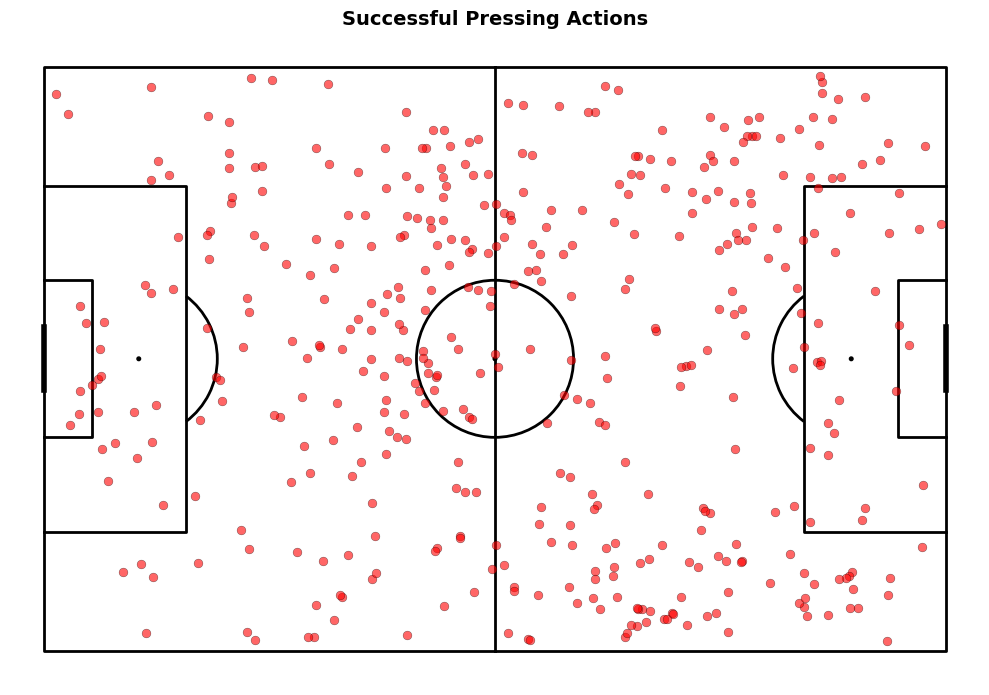

In [3]:
import pandas as pd
from mplsoccer import Pitch
import matplotlib.pyplot as plt

# Load your match events CSV
CSV_PATH = "/Users/user/IMPECT/Matches/events/KFC Komarno vs AS Trencin (2025-07-26).csv"
df = pd.read_csv(CSV_PATH)

# -------------------------
# Filter SUCCESSFUL presses
# -------------------------
pressing = df[
    (
        (df["pressingPlayerId"].notna()) | 
        (df["pressure"].fillna(0) > 0)
    ) &
    (df["result"] == "SUCCESS")
].copy()

# Coordinates
x = pressing["start_adjCoordinates_x"]
y = pressing["start_adjCoordinates_y"]

# -------------------------
# Plot
# -------------------------
pitch = Pitch(
    pitch_type="impect",
    pitch_length=105,
    pitch_width=68,
    pitch_color="white",
    line_color="black"
)

fig, ax = pitch.draw(figsize=(10, 7))

pitch.scatter(
    x,
    y,
    ax=ax,
    s=40,
    c="red",
    alpha=0.6,
    edgecolors="black",
    linewidth=0.3
)

ax.set_title(
    "Successful Pressing Actions",
    fontsize=14,
    fontweight="bold"
)

plt.show()


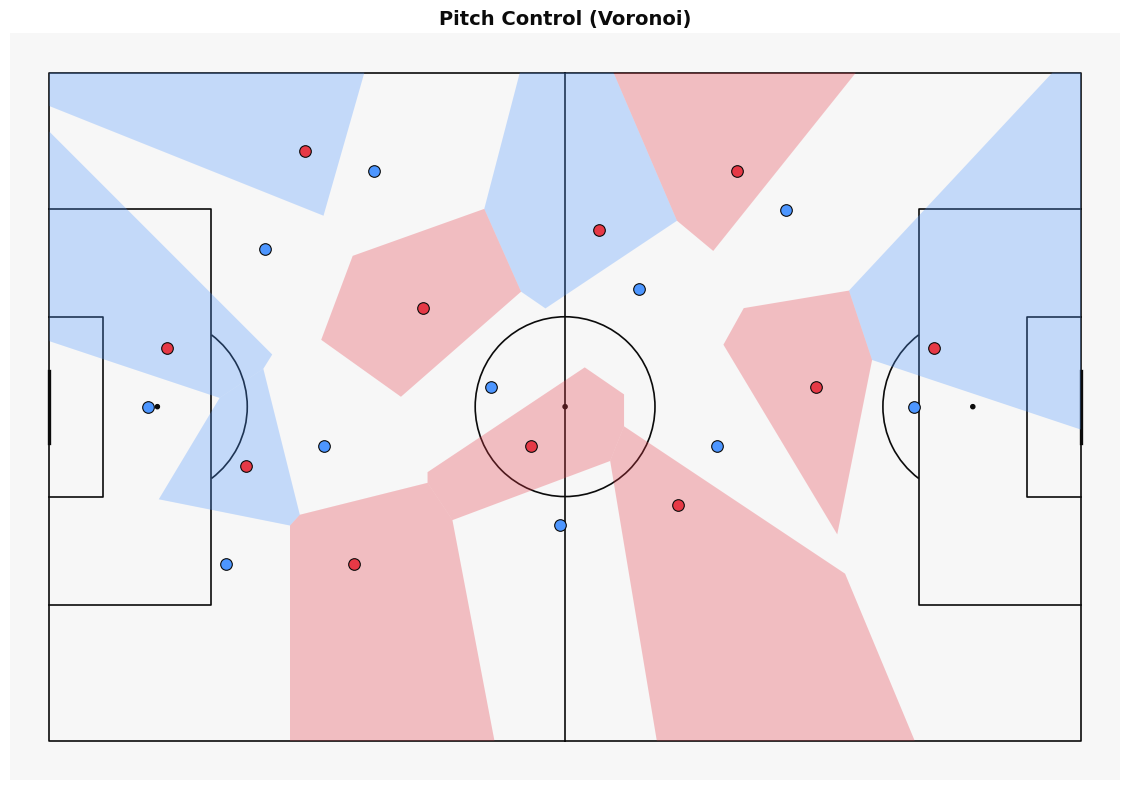

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from mplsoccer import Pitch

# --- COLOR PALETTE ---
OUTSWINGER = {
    "yellow":  "#F4C430",
    "black":   "#0B0B0B",
    "white":   "#F7F7F7",
    "grey":    "#9AA0A6",
    "emerald": "#2ECC71",
    "crimson": "#E63946",
    "blue":    "#4D96FF",
    "violet":  "#7B61FF",
}

# Example player positions
home_x = np.array([10, 18, 22, 28, 33, 45, 52, 60, 68, 75, 88])
home_y = np.array([34, 18, 50, 30, 58, 36, 22, 46, 30, 54, 34])

away_x = np.array([12, 20, 26, 31, 38, 49, 56, 64, 70, 78, 90])
away_y = np.array([40, 28, 60, 18, 44, 30, 52, 24, 58, 36, 40])

# Combine
x = np.concatenate([home_x, away_x])
y = np.concatenate([home_y, away_y])
teams = np.concatenate([
    np.zeros(len(home_x), dtype=int),
    np.ones(len(away_x), dtype=int)
])

# Pitch
pitch = Pitch(
    pitch_type="custom",
    pitch_length=105,
    pitch_width=68,
    pitch_color=OUTSWINGER["white"],
    line_color=OUTSWINGER["black"],
    linewidth=1.2
)

fig, ax = pitch.draw(figsize=(12, 8))

# Voronoi
polygons, poly_teams = pitch.voronoi(x, y, teams)

# ✅ ROBUST SPLIT
home_polys = []
away_polys = []

for poly, team in zip(polygons, poly_teams):
    # Reduce team label safely
    team_val = int(np.unique(np.asarray(team))[0])

    if team_val == 0:
        home_polys.append(poly)
    else:
        away_polys.append(poly)

# Draw pitch control
pitch.polygon(
    home_polys,
    ax=ax,
    fc=OUTSWINGER["blue"],
    ec=None,
    alpha=0.30,
    zorder=1
)

pitch.polygon(
    away_polys,
    ax=ax,
    fc=OUTSWINGER["crimson"],
    ec=None,
    alpha=0.30,
    zorder=1
)

# Players
pitch.scatter(home_x, home_y, ax=ax, s=70,
              c=OUTSWINGER["blue"], ec=OUTSWINGER["black"], lw=0.8, zorder=3)
pitch.scatter(away_x, away_y, ax=ax, s=70,
              c=OUTSWINGER["crimson"], ec=OUTSWINGER["black"], lw=0.8, zorder=3)

ax.set_title(
    "Pitch Control (Voronoi)",
    fontsize=14,
    fontweight="bold",
    color=OUTSWINGER["black"]
)

plt.show()
